## 分析A/B测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

此项目针对的是电子商务网站运行的 A/B 测试的结果。目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

<a id='probability'></a>
#### I - 概率


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。 

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
len(df)

294478

c. 数据集中独立用户的数量。

In [4]:
len(df['user_id'].unique())

290584

d. 用户转化的比例。

In [5]:
df['converted'].mean()

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
len(df[(df.group == 'treatment') & (df.landing_page == 'old_page')]) + len(df[(df.group == 'control') & (df.landing_page == 'new_page')])

3893


f. 是否有任何行存在缺失值？

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


不存在缺失值。

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。     
a. 创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df1 = df.drop(df.index[(df.group == 'treatment') & (df.landing_page == 'old_page')])
df2 = df1.drop(df1.index[(df1.group == 'control') & (df1.landing_page == 'new_page')])
len(df2)

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 一些问题

a.  **df2** 中有多少唯一的 **user_id**?

In [10]:
len(df2['user_id'].unique())

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [11]:
df2['user_id'].value_counts()

773192    2
630732    1
811737    1
797392    1
795345    1
801490    1
799443    1
787157    1
793302    1
817882    1
842446    1
815835    1
805596    1
803549    1
809694    1
807647    1
895712    1
840399    1
836301    1
899810    1
834242    1
936604    1
934557    1
940702    1
938655    1
830144    1
828097    1
832195    1
838348    1
821956    1
         ..
734668    1
736717    1
730574    1
775632    1
771538    1
642451    1
773587    1
783828    1
785877    1
779734    1
781783    1
759256    1
726472    1
748999    1
746950    1
753093    1
751044    1
740803    1
738754    1
744897    1
742848    1
634271    1
632222    1
636316    1
630169    1
650647    1
648598    1
654741    1
652692    1
630836    1
Name: user_id, Length: 290584, dtype: int64

是user_id为773192的用户。

c. 这个重复的  **user_id** 的行信息是什么？

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [13]:
df2.drop(index = 1899, inplace = True)
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` 一些问题

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [14]:
df2['converted'].mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [15]:
df2[df2.group == 'control']['converted'].mean()

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [16]:
df2[df2.group == 'treatment']['converted'].mean()

0.11880806551510564

In [17]:
a_diffs = df2[df2.group == 'treatment']['converted'].mean() - df2[df2.group == 'control']['converted'].mean()
a_diffs

-0.0015782389853555567

d. 一个用户收到新页面的概率是多少？


In [18]:
len(df2[df2.landing_page == 'new_page']) / len(df2)

0.5000619442226688

e. 认为没有证据表明新的页面带来了更多转化，相反，新页面的转化低于旧页面。

<a id='ab_test'></a>
### II - A/B 测试


`1.` 零假设：新的页面转化等于或者小于旧的页面。即： p_n <= p_o   
备择假设：新的页面转化大于旧的页面。即： p_n > p_o

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [19]:
p_n = df2['converted'].mean()
p_n

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [20]:
p_o = df2['converted'].mean()
p_o

0.11959708724499628

c.  $n_{new}$ 是多少？

In [21]:
n_n = len(df2[df2.landing_page == 'new_page'])
n_n

145310

d.  $n_{old}$?是多少？

In [22]:
n_o = len(df2[df2.landing_page == 'old_page'])
n_o

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [23]:
new_page_converted = np.random.choice([0,1], size = n_n, p = [ (1-p_n), p_n])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [24]:
old_page_converted = np.random.choice([0,1], size = n_o, p = [ (1-p_o), p_o])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [25]:
m_diffs = new_page_converted.mean() - old_page_converted.mean()
m_diffs

-0.0002637395544585336

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [26]:
p_diffs = []
for i in range(10000):
    p_n_s = np.random.choice([0,1], size = 145310, p = [ (1-p_n), p_n]).mean()
    p_o_s = np.random.choice([0,1], size = 145274, p = [ (1-p_o), p_o]).mean()
    p_diffs.append(p_n_s - p_o_s)

i. 绘制一个 **p_diffs** 直方图。

Text(0.5,1,'p_diffs in model')

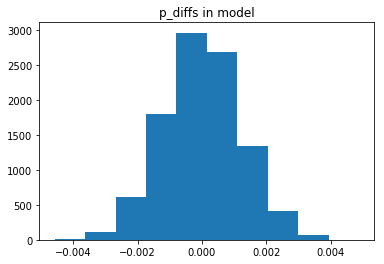

In [27]:
plt.hist(p_diffs)
plt.title('p_diffs in model')

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

In [28]:
(p_diffs > a_diffs).mean()

0.9051

k. **说明在零假设成立的前提下，观察到的样本统计量很大程度来源于零假设（>0.05），不拒绝零假设。这个值叫做P值。根据这个值，应该选择零假设，即新页面转化率小于或者等于旧页面。**


l. 也可以使用一个内置程序 （built-in）来实现类似的结果。

In [29]:
import statsmodels.api as sm

convert_old = df2[df2.landing_page == 'old_page']['converted'].sum()
convert_new = df2[df2.landing_page == 'new_page']['converted'].sum()
n_old = len(df2[df2.landing_page == 'old_page'])
n_new = len(df2[df2.landing_page == 'new_page'])
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. 现在使用 `stats.proportions_ztest` 来计算检验统计量与 p-值。

In [30]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. **这里的P值也大于0.05，即不拒绝零假设,新旧页面转化率没有明显区别**

<a id='regression'></a>
### III - 回归分析法之一

`1.` 也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，应该**逻辑回归。**

b. 目标是使用 **statsmodels** 来拟合 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [31]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0



c. 使用 **statsmodels** 导入回归模型。 实例化该模型，并使用 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [32]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d.模型摘要。

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        00:57:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 ab_page 关联的 p值是0.190。这里的p值代表的含义是ab_page参数与反应变量之间不具有统计显著性。
在回归模型中，零假设是解释变量的斜率等于零，备择假设是解释变量的斜率不等于零。 在假设检验中，零假设是新旧转化率差小于等于零，备择假设是转化率差大于零。



f. 将其他变量添加到回归模型中，可以有利于看出哪个解释变量对于反应变量来讲最具有统计显著性，从而找到问题的关键。但是，添加附加项时，如果新加的附加项与已有附加项相关性较强，则产生的结果不可靠，不能作为判断依据。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。

In [34]:
df_c = pd.read_csv('countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
len(df_c['user_id'].unique())

290584

In [36]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
control         290584 non-null uint8
ab_page         290584 non-null uint8
dtypes: int64(3), object(3), uint8(2)
memory usage: 16.1+ MB


In [38]:
df3 = df2.set_index('user_id').join(df_c.set_index('user_id'))
df3.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [39]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1


In [41]:
sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 02 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        00:57:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

从P值可以看出，国家项对转化率不具有统计显著性，没有影响。

h. 虽然现在已经查看了国家与页面在转化率上的个体性因素，但现在要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

In [42]:
df3[['new_page', 'old_page']] = pd.get_dummies(df3['landing_page'])
df3.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,new_page,old_page
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,1


In [43]:
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
df3.head()

,timestamp,group,landing_page,converted,intercept,control,ab_page,country,CA,UK,US,new_page,old_page,new_CA,new_UK
user_id,,,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US,0,0,1,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,0,1,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,1,0,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,1,0,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US,0,0,1,0,1,0,0


In [44]:
sm.Logit(df3['converted'], df3[['intercept', 'new_CA', 'new_UK', 'new_page', 'CA', 'UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Sep 2018   Pseudo R-squ.:               3.482e-05
Time:                        00:57:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
new_page      -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
==============================================================================
"""

new_CA和new_UK变量的P值均大于0.05，可以认为，该变量对转化率不具有统计显著性，不会对转化率产生明显影响。

### 结论：在用逻辑回归判断不同变量对转化率的影响时，可以看到，单独的页面类型和国家，以及页面和国家的综合因素都未对转化率产生明显影响。为此不能拒绝零假设，即新页面的转化率小于等于旧页面，不需要对页面进行更新。

## 参考资料：无。